# Random Forest

In [1]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
import joblib
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
print(os.getcwd())


/Users/anqiwang/Desktop/lab4/stat-215-group/lab4/code/Modelling


In [3]:
image_1 = pd.read_csv("../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../data/image_data/image3.txt", delim_whitespace=True, header=None)

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_82911/4066135236.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_82911/4066135236.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_82911/4066135236.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../data/image_data/image3.txt", delim_whitespace=True, header=None)


In [4]:
column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names

# Train on image 1 and validate on image 2
we remove uncertain data to train the model, and we use the entire dataset for prediction 
for accuracy, we have to remove uncertain data also

In [5]:
# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# select all features except the expert_label column from dataset and call it x
x_train1 = train_on1.drop(columns=['expert_label']) # explanatory variables 
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data

In [7]:
# Model 1: training using the default parameter 
rf = RandomForestClassifier()
rf.fit(x_train1, y_train1)
y_pred_on2 = rf.predict(image_2.drop(columns=['expert_label'])) #prediction using entire image 2 data
accuracy_model_1 = rf.score(validate_on2.drop(columns=['expert_label']), validate_on2['expert_label']) #accuracy of the model (have to drop )

In [8]:
from sklearn.metrics import classification_report
print(classification_report(validate_on2['expert_label'], rf.predict(validate_on2.drop(columns=['expert_label']))))

              precision    recall  f1-score   support

        -1.0       0.84      0.79      0.81     42882
         1.0       0.78      0.84      0.81     39266

    accuracy                           0.81     82148
   macro avg       0.81      0.81      0.81     82148
weighted avg       0.81      0.81      0.81     82148



In [9]:
features = pd.DataFrame(rf.feature_importances_, index=x_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
features

,importance
NDAI,0.332667
Radiance_angle_AF,0.139964
y_coor,0.112769
Radiance_angle_BF,0.101672
x_coor,0.083891
SD,0.076742
Radiance_angle_AN,0.064822
Radiance_angle_CF,0.049821
Radiance_angle_DF,0.022037
CORR,0.015614


model 1 gives a 82% accuracy 

## Now I try to pick the best hyperparameters through grid search. I tune the hyperparameters for the full model by running the train1hyper.py file on SCF. The results for the best hyperparameters in the full model are saved in results folder. 

In [6]:
#load csv file
hyper_p_results = pd.read_csv("../../results/grid_search_results1.csv") #this is the grid search result for choosing the hyperparameters

## best score: 85.758% accuracy
## best hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
## random state=42

In [7]:
rf_best_hyper1 = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, bootstrap=True, criterion='entropy', random_state=42)

In [8]:
rf_best_hyper1.fit(x_train1, y_train1)
y_pred_on2 = rf_best_hyper1.predict(image_2.drop(columns=['expert_label'])) #prediction using entire image 2 data (including uncertain data)
accuracy_full_model = rf_best_hyper1.score(validate_on2.drop(columns=['expert_label']), validate_on2['expert_label']) #accuracy of the model (not including uncertain data)
accuracy_full_model

0.8575863076398695

In [10]:
from sklearn.metrics import classification_report
print(classification_report(validate_on2['expert_label'], rf_best_hyper1.predict(validate_on2.drop(columns=['expert_label']))))

              precision    recall  f1-score   support

        -1.0       0.87      0.85      0.86     42882
         1.0       0.84      0.87      0.85     39266

    accuracy                           0.86     82148
   macro avg       0.86      0.86      0.86     82148
weighted avg       0.86      0.86      0.86     82148



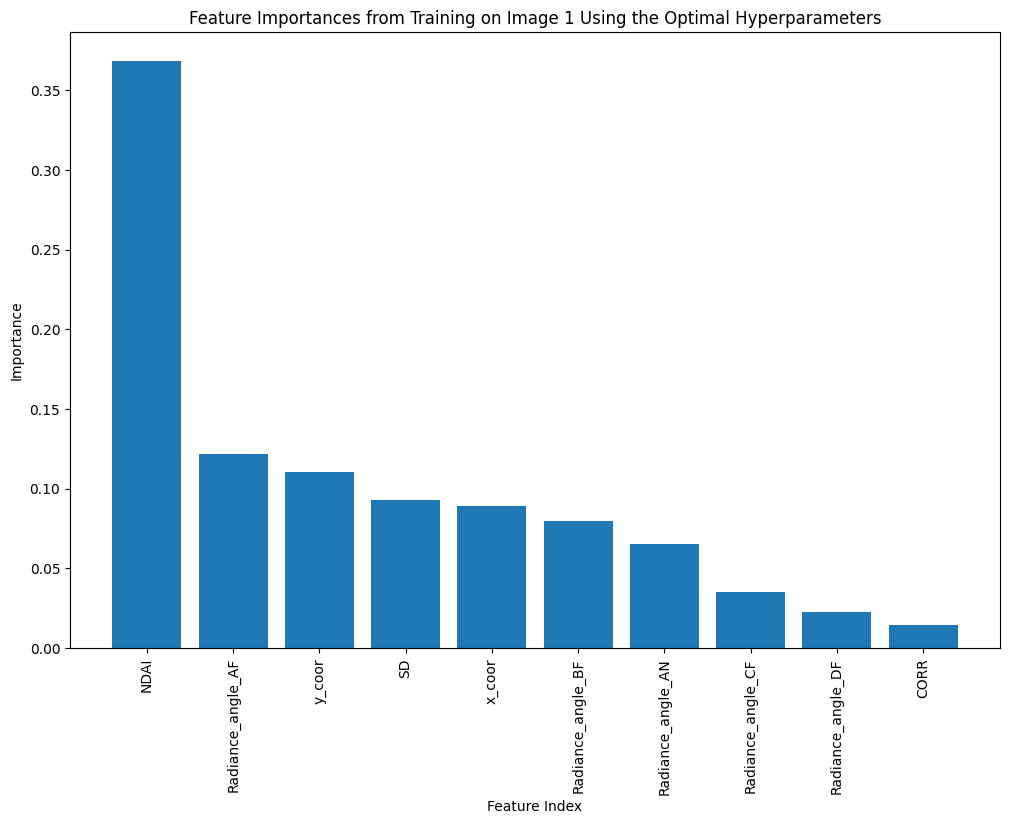

In [11]:
features = pd.DataFrame(rf_best_hyper1.feature_importances_, index=x_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
features

plt.figure(figsize=(12, 8))
plt.bar(features.index, features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Training on Image 1 Using the Optimal Hyperparameters')
plt.xticks(ticks=features.index, rotation=90)
plt.show()

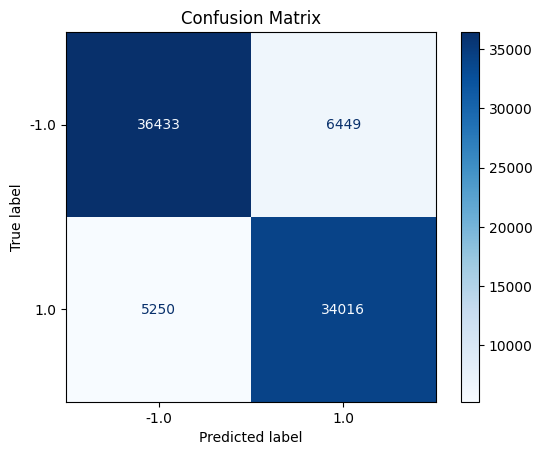

In [12]:
#predict using rf_best_hyper1 on image 2 data
confusion_matrix1 = confusion_matrix(validate_on2['expert_label'], rf_best_hyper1.predict(validate_on2.drop(columns=['expert_label'])))
confusion_matrix1

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=rf_best_hyper1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Train on image 2 and validate on image 1

In [ ]:
# remove when expert label is zero (remove uncertain data)
train_on2 = image_2[image_2['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
x_train2 = train_on2.drop(columns=['expert_label']) # explanatory variables 
y_train2 = train_on2['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on1 = image_1[image_1['expert_label'] != 0] # remove uncertain data

## Now I try to pick the best hyperparameters through grid search. I tune the hyperparameters for the full model by running the train2hyper.py file on SCF. The results for the best hyperparameters in the full model are saved in results folder. 

In [18]:
#load csv file
hyper_p_results2 = pd.read_csv("../../results/grid_search_results2.csv") #this is the grid search result for choosing the hyperparameters

## prediction accuracy for the best hyperparameters: 86.6%
## the best hyperparameters are: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

## random state=42

In [19]:
rf_best_hyper2 = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=2, bootstrap=True, criterion='entropy', random_state=42)

In [20]:
rf_best_hyper2.fit(x_train2, y_train2)
y_pred_on1 = rf_best_hyper2.predict(image_1.drop(columns=['expert_label'])) #prediction using entire image 1 data (including uncertain data)
accuracy_full_model = rf_best_hyper2.score(validate_on1.drop(columns=['expert_label']), validate_on1['expert_label']) #accuracy of the model (not including uncertain data)
accuracy_full_model

0.8663367034702539

In [22]:
from sklearn.metrics import classification_report
print(classification_report(validate_on1['expert_label'], rf_best_hyper2.predict(validate_on1.drop(columns=['expert_label']))))

              precision    recall  f1-score   support

        -1.0       0.87      0.95      0.91     50446
         1.0       0.85      0.66      0.74     20471

    accuracy                           0.87     70917
   macro avg       0.86      0.80      0.82     70917
weighted avg       0.86      0.87      0.86     70917



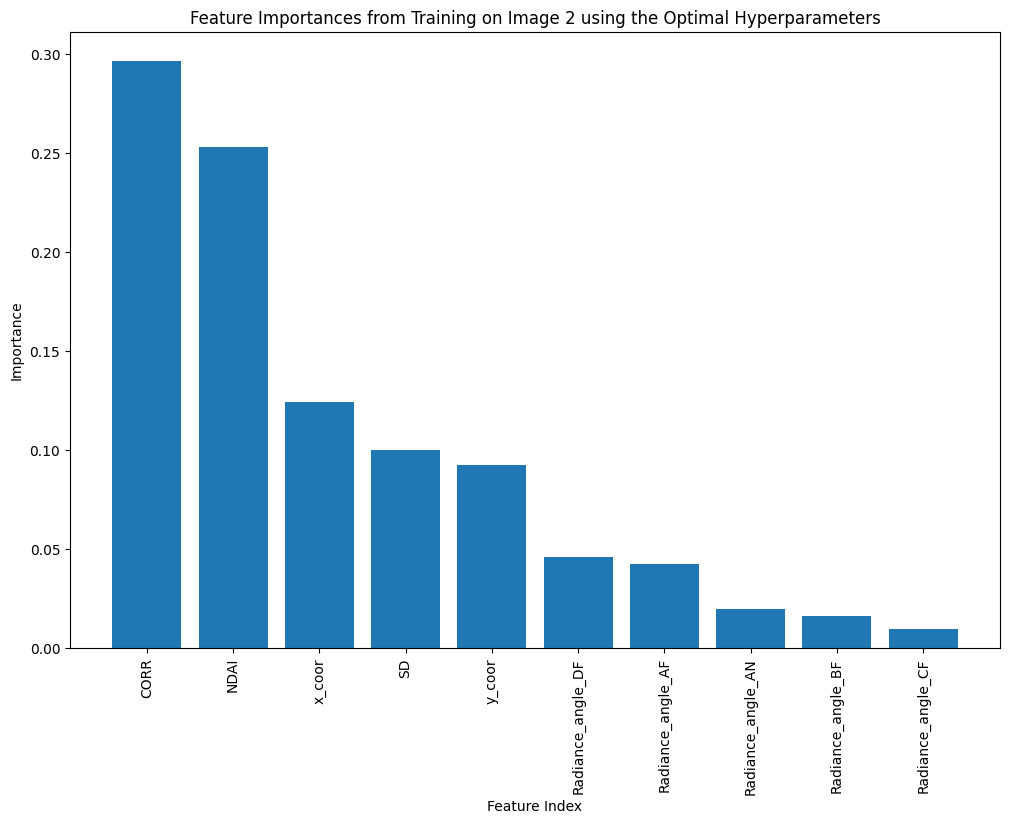

In [ ]:
#Features importance 
features = pd.DataFrame(rf_best_hyper2.feature_importances_, index=x_train2.columns, columns=['importance']).sort_values('importance', ascending=False)
features

plt.figure(figsize=(12, 8))
plt.bar(features.index, features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances from Training on Image 2 Using the Optimal Hyperparameters')
plt.xticks(ticks=features.index, rotation=90)
plt.show()

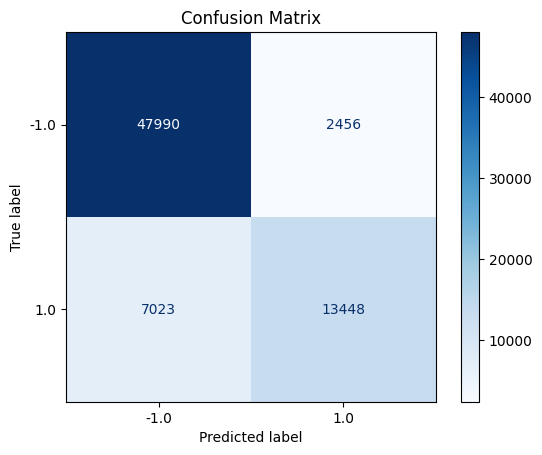

In [36]:
confusion_matrix2 = confusion_matrix(validate_on1['expert_label'], rf_best_hyper2.predict(validate_on1.drop(columns=['expert_label'])))
confusion_matrix2

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2, display_labels=rf_best_hyper2.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# below is just testing my python script for tuning hyperparameters for SCF, can ignore

In [ ]:
# import packages and load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names

# remove when expert label is zero (remove uncertain data)
train_on1 = image_1[image_1['expert_label'] != 0]


# select all features except the expert_label column from dataset and call it x
x_train1 = train_on1.drop(columns=['expert_label']) # explanatory variables 
y_train1 = train_on1['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on2 = image_2[image_2['expert_label'] != 0] # remove uncertain data


# Try to tune the hyperparameters using gridsearch and cross validation (train on 1 and validate on 2)
rf = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [100, 200, 300], # number of trees in the forest, default=100. usually more trees better performance
#'max_depth': [None, 10, 20, 30], # the maximum depth of the tree, default=none. may lead to overfitting if the depth too large
#'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node, default=2 (the node will split as long as it has at least 2 samples). high values prevent overfitting
#'min_samples_leaf': [1, 2, 4], # the minimum number of samples required to be at a leaf node, default=1. large values prevent overfitting
#'criterion': ['gini', 'entropy'], # the function to measure the quality of a split, default=gini. 
#'bootstrap': [True, False] # whether bootstrap samples are used when building trees, default=True
}


# Create a validation fold
X = pd.concat([train_on1.drop(columns=['expert_label']), validate_on2.drop(columns=['expert_label'])], ignore_index=True)
y = pd.concat([train_on1['expert_label'], validate_on2['expert_label']], ignore_index=True)

# Create a validation fold: -1 for training data on image 1, 0 for validation data on image 2
test_fold = [-1] * len(train_on1) + [0] * len(validate_on2)
ps = PredefinedSplit(test_fold)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=ps, n_jobs=-1)

#fit the model 
grid_search.fit(X, y)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Create a dictionary to hold the best parameters and score
results = {
    'best_score': [best_score],
    'best_params': [best_params]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('grid_search_results1.csv', index=False)

# Save the best model
joblib.dump(best_rf, 'best_random_forest_model.pkl')

In [1]:
# Tuning the hyparameter when training on image 2 and validate on image 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import os
from pyreadr import read_r
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import joblib

image_1 = pd.read_csv("../../data/image_data/image1.txt", delim_whitespace=True, header=None)
image_2 = pd.read_csv("../../data/image_data/image2.txt", delim_whitespace=True, header=None)
image_3 = pd.read_csv("../../data/image_data/image3.txt", delim_whitespace=True, header=None)

column_names = ['y_coor', 'x_coor', 'expert_label', 'NDAI', 'SD', 'CORR', 'Radiance_angle_DF','Radiance_angle_CF','Radiance_angle_BF','Radiance_angle_AF', 'Radiance_angle_AN'] 
image_1.columns = column_names
image_2.columns = column_names
image_3.columns = column_names

# remove when expert label is zero (remove uncertain data)
train_on2 = image_2[image_2['expert_label'] != 0]

# select all features except the expert_label column from dataset and call it x
x_train2 = train_on2.drop(columns=['expert_label']) # explanatory variables 
y_train2 = train_on2['expert_label'] # response variable we want to predict

# below are datasets we should use for caculating prediction accuracy using image 2
validate_on1 = image_1[image_1['expert_label'] != 0] # remove uncertain data


# Try to tune the hyperparameters using gridsearch and cross validation (train on 1 and validate on 2)
rf = RandomForestClassifier(random_state=42)
param_grid = {
'n_estimators': [100, 200, 300], # number of trees in the forest, default=100. usually more trees better performance
#'max_depth': [None, 10, 20, 30], # the maximum depth of the tree, default=none. may lead to overfitting if the depth too large
#'min_samples_split': [2, 5, 10], # the minimum number of samples required to split an internal node, default=2 (the node will split as long as it has at least 2 samples). high values prevent overfitting
#'min_samples_leaf': [1, 2, 4], # the minimum number of samples required to be at a leaf node, default=1. large values prevent overfitting
#'criterion': ['gini', 'entropy'], # the function to measure the quality of a split, default=gini. 
#'bootstrap': [True, False] # whether bootstrap samples are used when building trees, default=True
}


# Create a validation fold
X = pd.concat([train_on2.drop(columns=['expert_label']), validate_on1.drop(columns=['expert_label'])], ignore_index=True)
y = pd.concat([train_on2['expert_label'], validate_on1['expert_label']], ignore_index=True)

# Create a validation fold: -1 for training data on image 1, 0 for validation data on image 2
test_fold = [-1] * len(train_on2) + [0] * len(validate_on1)
ps = PredefinedSplit(test_fold)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=ps, n_jobs=26)

#fit the model 
grid_search.fit(X, y)

best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Create a dictionary to hold the best parameters and score
results = {
    'best_score': [best_score],
    'best_params': [best_params]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_df.to_csv('grid_search_results2.csv', index=False)

# Save the best model
joblib.dump(best_rf, 'best_random_forest_model2.pkl')

/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_79617/2439505383.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_1 = pd.read_csv("../../data/image_data/image1.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_79617/2439505383.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_2 = pd.read_csv("../../data/image_data/image2.txt", delim_whitespace=True, header=None)
/var/folders/g8/lhr36xwd1_lgrsqvt5fsvcvc0000gn/T/ipykernel_79617/2439505383.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_3 = pd.read_csv("../../data/image_data/image3.txt", delim_whitespace=True, header=None)


['best_random_forest_model2.pkl']